# The netCDF file format

* popular scientific file format for ocean and atmospere gridded datasets
* netCDF is a collection of formats for storing arrays

    * netCDF classic
        * more widespread
        * 2 GB file limit
        * often preffered for distributing products

    * netCDF 64 bit offset
        * supports larger files

    * NetCDF4
        * based on HDF5
        * compression
        * multiple unlimited variables
        * new types inc. user defined
        * herarchical groups
        
        

* Developed by Unidata-UCAR with the aim of storing climate model data (3D+time)
* Auxilary information about each variable can be added
* Readable text equivalent called CDL (use ncdump/ncgen)
* Can be used with Climate and Forecast (CF) data convention
http://cfconventions.org/

## Data model:

* Dimensions:describe the axes of the data arrays.
* Variables: N-dimensional arrays of data.
* Attributes: annotate variables or files with small notes or supplementary metadata.

Example for an ocean model dataset:

* Dimensions
    * lat
    * lon
    * depth
    * time
* Variable
    * Temperature
    * Salinity
* Global Attibutes
    * Geographic grid type
    * History



* Variable attributes (Temperature)
    * Long_name: "sea water temperature" 
    * Missing_value: 1.09009E36
    * Units: deg. C
    * range: -2:50

## Tools for working with netCDF files

### C and Fortran libraries
Used to underpin interfaces to other languages such as python (e.g. python package netCDF4)

Include ncdump/ncgen to convert to and from human readable CDL format.

### nco tools http://nco.sourceforge.net/nco.html

Command line utilities to extract, create and operate data in netCDF files.

``> ncks -v u_wind -d lat,50.,51. -d lon,0.,5 inputfile.nc outputfile.nc``

### Viewers
ncview, pyncview, panoply, etc...

### Imported by many packages
ArcGIS, QGIS, Surfer,Ferret etc...


# Working With netCDF files using xarray

* Alternative to plain netCDF4 access from python. 

* Brings the power of pandas to environmental sciences, by providing N-dimensional variants of the core pandas data structures:

* worth using for multidimensional data even when not using 

| Pandas | xarray  |
|---|---|
| Series  | DataArray  |
| DataFrame  | Dataset  |


DataArray uses names of dimensions making it easier to track than by using axis numbers. It is possible to write:

``da.sel(time='2000-01-01')`` or ``da.mean(dim='time')`` 
intead of ``df.mean(0)``

    HTML documentation: http://xarray.pydata.org/
    


## Example dataset
http://xray.readthedocs.io/en/stable/data-structures.html

<br>
<img src="../figures/dataset-diagram.png">


In [390]:
# Import everything that we are going to need... but not more
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
%matplotlib inline

In [391]:
DF=pd.DataFrame.from_items([('A', [1, 2, 3]), ('B', [4, 5, 6])],                         
                        orient='index', columns=['one', 'two', 'three'])
DF.mean(0)

one      2.5
two      3.5
three    4.5
dtype: float64

In [392]:
pd_s=pd.Series(range(3), index=list('abc'), name='foo')
print(pd_s)
print()

#conver 1D series to ND aware dataArray 
print(xr.DataArray(pd_s))

a    0
b    1
c    2
Name: foo, dtype: int32

<xarray.DataArray 'foo' (dim_0: 3)>
array([0, 1, 2])
Coordinates:
  * dim_0    (dim_0) object 'a' 'b' 'c'


### The main advantages of using xarray versus plain netCDF4 are:

* intelligent selection along labelled dimensions (and also indexes)
* groupby operations
* data alignment
* IO (netcdf)
* conversion from and to Pandas.DataFrames

### Lets peek inside our example file using ncdump

``
$ ncdump data/cefas_GETM_nwes.nc | more
netcdf cefas_GETM_nwes {
dimensions:
        latc = 360 ;
        lonc = 396 ;
        time = UNLIMITED ; // (6 currently)
        level = 5 ;
variables:
        double bathymetry(latc, lonc) ;
                bathymetry:units = "m" ;
                bathymetry:long_name = "bathymetry" ;
                bathymetry:valid_range = -5., 4000. ;
                bathymetry:_FillValue = -10. ;
                bathymetry:missing_value = -10. ;
        float h(time, level, latc, lonc) ;
                h:units = "m" ;
                h:long_name = "layer thickness" ;
                h:_FillValue = -9999.f ;
                h:missing_value = -9999.f ;
        double latc(latc) ;
                latc:units = "degrees_north" ;
        double level(level) ;
                level:units = "level" ;
        double lonc(lonc) ;
                lonc:units = "degrees_east" ;
        float temp(time, level, latc, lonc) ;
                temp:units = "degC" ;
                temp:long_name = "temperature" ;
                temp:valid_range = -2.f, 40.f ;
                temp:_FillValue = -9999.f ;
                temp:missing_value = -9999.f ;
        double time(time) ;
                time:long_name = "time" ;
                time:units = "seconds since 1996-01-01 00:00:00" ;
``

Now let's go back to python and use xarray.

## Import remote dataset

xarray supports OpenDAP. This means that a dataset can be accessed remotely and subsetted as needed. Only the selected parts are downloaded.

In [393]:
# Naughty datasets might require decode_cf=False
# Here it just needed decode_times=False

naughty_data = xr.open_dataset(
      'http://iridl.ldeo.columbia.edu/SOURCES/.OSU/.PRISM/.monthly/dods',
      decode_times=False)
naughty_data

<xarray.Dataset>
Dimensions:  (T: 1422, X: 1405, Y: 621)
Coordinates:
  * X        (X) float32 -125.0 -124.958 -124.917 -124.875 -124.833 -124.792 ...
  * T        (T) float32 -779.5 -778.5 -777.5 -776.5 -775.5 -774.5 -773.5 ...
  * Y        (Y) float32 49.9167 49.875 49.8333 49.7917 49.75 49.7083 ...
Data variables:
    ppt      (T, Y, X) float64 ...
    tdmean   (T, Y, X) float64 ...
    tmax     (T, Y, X) float64 ...
    tmin     (T, Y, X) float64 ...
Attributes:
    expires: 1375315200
    Conventions: IRIDL

### ...or import local dataset

In [394]:
GETM = xr.open_dataset('../data/cefas_GETM_nwes.nc4')
GETM

<xarray.Dataset>
Dimensions:     (latc: 360, level: 5, lonc: 396, time: 6)
Coordinates:
  * latc        (latc) float64 45.4 45.45 45.5 45.55 45.6 45.65 45.7 45.75 ...
  * level       (level) float64 1.0 6.0 11.0 16.0 21.0
  * lonc        (lonc) float64 -17.5 -17.42 -17.34 -17.26 -17.18 -17.1 ...
  * time        (time) datetime64[ns] 1996-02-01T01:00:00 ...
Data variables:
    bathymetry  (latc, lonc) float64 nan nan nan nan nan nan nan nan nan nan ...
    h           (time, level, latc, lonc) float64 nan nan nan nan nan nan ...
    temp        (time, level, latc, lonc) float64 nan nan nan nan nan nan ...
Attributes:
    title: North West European Shelf 3nm
    history: Sun Nov 20 00:54:48 2016: ncks -v time,latc,lonc,level,temp,bathymetry,h -d time,0,120,24 -d level,1,25,5 /gpfs/afmcefas/share/nwes/36x36_old/timebase/nwes-3d-199602.nc cefas_GETM_nwes.nc
Mon May  9 18:50:36 2016: ncatted -a units,time,o,c,seconds since 1996-01-01 00:00:00 /gpfs/afmcefas/share/nwes/36x36_old//timebase//n

In [395]:
GETM.dims

Frozen(SortedKeysDict({'level': 5, 'latc': 360, 'lonc': 396, 'time': 6}))

In [396]:
print(type(GETM.coords['latc']))
GETM.coords['latc'].shape

<class 'xarray.core.dataarray.DataArray'>


(360,)

In [397]:
# List name of dataset attributes
GETM.attrs.keys()

odict_keys(['title', 'history', 'NCO', 'nco_openmp_thread_number'])

In [398]:
# List variable names
GETM.data_vars.keys()

KeysView(Data variables:
    bathymetry  (latc, lonc) float64 nan nan nan nan nan nan nan nan nan nan ...
    h           (time, level, latc, lonc) float64 nan nan nan nan nan nan ...
    temp        (time, level, latc, lonc) float64 nan nan nan nan nan nan ...)

Extract variable from dataset

In [399]:
temp=GETM['temp']
print(type( temp ))
temp.shape

<class 'xarray.core.dataarray.DataArray'>


(6, 5, 360, 396)

Access variable attributes

In [633]:
# print varaible attributes

for at in temp.attrs:
    print(at+':\t\t',end=' ')
    print(temp.attrs[at])

units:		 degC
long_name:		 temperature
valid_range:		 [ -2.  40.]


## Accessing data values

In [400]:
temp[0,0,90,100]

<xarray.DataArray 'temp' ()>
array(11.532867431640625)
Coordinates:
    latc     float64 49.9
    level    float64 1.0
    lonc     float64 -9.5
    time     datetime64[ns] 1996-02-01T01:00:00
Attributes:
    units: degC
    long_name: temperature
    valid_range: [ -2.  40.]

## Indexing and selecting data

From http://xarray.pydata.org/
<br>
<img src="../figures/xarray_indexing_table.png">



In [401]:
#positional by integer
print( temp[0,2,:,:].shape )

# positional by label
print( temp.loc['1996-02-02T01:00:00',:,:,:].shape )

# by name and integer
print( temp.isel(level=1,latc=90,lonc=100).shape )

# by name and label
print( temp.sel(time='1996-02-02T01:00:00').shape )
#temp.loc

(360, 396)
(5, 360, 396)
(6,)
(5, 360, 396)


### Define selection using nearest value

In [538]:
#GETM.sel(level=1)['temp']
GETM['temp'].sel(level=1,lonc=-5.0,latc=-50.0, method='nearest')

<xarray.DataArray 'temp' (time: 6)>
array([ nan,  nan,  nan,  nan,  nan,  nan])
Coordinates:
    latc     float64 45.4
    level    float64 1.0
    lonc     float64 -5.02
  * time     (time) datetime64[ns] 1996-02-01T01:00:00 1996-02-02T01:00:00 ...
Attributes:
    units: degC
    long_name: temperature
    valid_range: [ -2.  40.]

In [539]:
try:
    GETM['temp'].sel(level=1,lonc=-5.0,latc=-50.0, method='nearest',tolerance=0.5)
except KeyError:
    print('ERROR: outside tolerance of '+str(0.5))

ERROR: outside tolerance of 0.5


## Plotting

In [600]:
# Define a general mapping function using basemap

def do_map(var,title,units):
    latc=GETM.coords['latc'].values
    lonc=GETM.coords['lonc'].values

    # create figure and axes instances
    fig = plt.figure()
    ax = fig.add_axes()
    # create polar stereographic Basemap instance.
    m = Basemap(projection='stere', lon_0=0.,lat_0=60.,
            llcrnrlat=49,urcrnrlat=60,
            llcrnrlon=-10,urcrnrlon=15,resolution='l')
    # bondaries resolution can be 'c','l','i','h' or 'f'

    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='0.8')

    parallels = np.arange(-45,70,5)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    m.drawparallels?
    meridians = np.arange(-15,20,5)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

    # create arrays of coordinates for contourf
    lon2d,lat2d=np.meshgrid(lonc,latc)

    # draw filled contours.
    m.contourf(lon2d,lat2d,var,50,latlon=True)

    # add colorbar.
    cbar = m.colorbar(cmap=plt.cm.coolwarm,location='right')
    cbar.set_label(units)

    # add title
    plt.title(title)


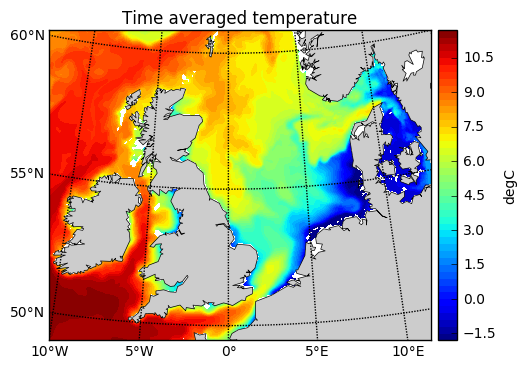

In [606]:
# Extract attributes

units=GETM['temp'].attrs['units']
var_long_name=GETM['temp'].attrs['long_name']

# and plot
do_map(var=time_ave.sel(level=21),
       units=units,
       title='Time averaged '+var_long_name)


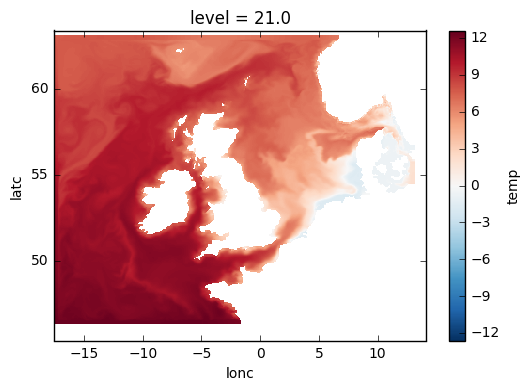

In [611]:
# But often, this will do
time_ave.sel(level=21).plot()

## Arithmetic operations

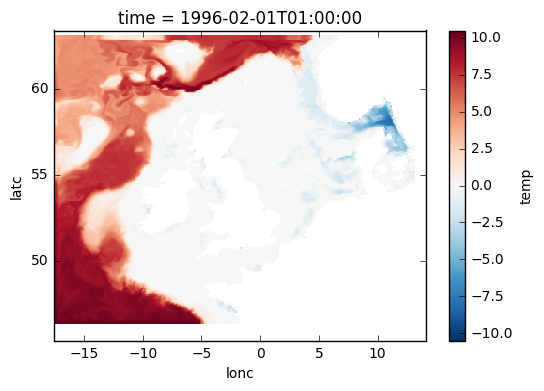

In [593]:
top=GETM['temp'].isel(time=0,level=4)
bottom=GETM['temp'].isel(time=0,level=0)

diff=top-bottom

diff.plot()

### Calculate average along a dimension

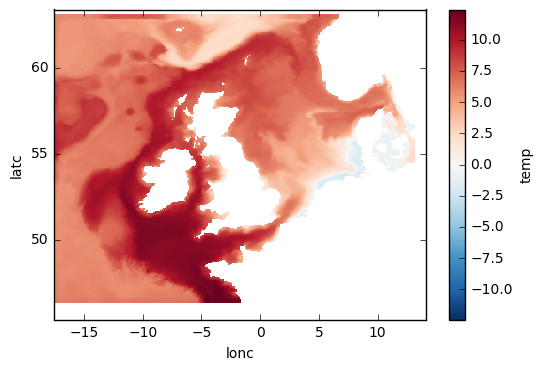

In [634]:
# average over time
time_ave = GETM['temp'].mean('time')

#average over time and level (vertical)
timelev_ave=GETM['temp'].mean(['time','level'])

timelev_ave.plot()




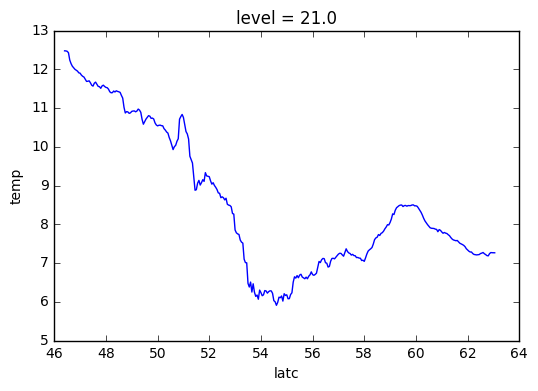

In [636]:
#zonal average (vertical)
timelon_ave=GETM['temp'].mean(['time','lonc']).isel(level=4)

timelon_ave.plot()

## A dataset can easily be saved to a netCDF file

In [637]:
ds=GETM[['temp']].mean('time','level')
ds.to_netcdf('../data/temp_avg_level_time.nc')

In [638]:
print(type( GETM[['temp']]) )
print(type( GETM['temp'])   )


<class 'xarray.core.dataset.Dataset'>
<class 'xarray.core.dataarray.DataArray'>


<xarray.Dataset>
Dimensions:  (latc: 360, lonc: 396)
Coordinates:
  * latc     (latc) float64 45.4 45.45 45.5 45.55 45.6 45.65 45.7 45.75 45.8 ...
  * lonc     (lonc) float64 -17.5 -17.42 -17.34 -17.26 -17.18 -17.1 -17.02 ...
Data variables:
    temp     (latc, lonc) float64 nan nan nan nan nan nan nan nan nan nan ...

## Exercise

* Extract the bathymetry
* Extract the seabed temperature    isel(level=0)
* Produce a scatter plot of depth vs. seabed temperature


In [608]:
# bathy = GETM

# bedtemp=GETM

# plt.scatter(  , ,marker='.')